# SMS Messages Classification

Using the provided data, create a supervised learning model that will accurately classify which messages are spam.

## Import software libraries and load the dataset

In [1]:
# Library import

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import string

from keras.layers import Dense, Embedding, LSTM 
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from imblearn.over_sampling import SMOTE
from nltk import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time 

Data were downloaded in txt format from https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection.

In [2]:
# Load the dataset

data_root_dir = '.'
data_path = os.path.join(data_root_dir, 'smsspamcollection')
data_file = os.path.join(data_path, 'SMSSpamCollection')
data = pd.read_csv(data_file, sep ='\t',names=['label', 'message'])

## Get acquainted with the dataset

In [3]:
# View features and data types

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


The results show that the dataset has a total of 5572 records and that no column has a null value.

In [4]:
# View first 10 records

data.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


The content of the messages is not clear, in other words the messages contain special characters, upper and lower case letters, numbers. In addition, labels and messages are strings, which is not a format used by machine learning. The message content needs to be cleaned, and the string format needs to be converted.

In [5]:
# View the number of messages per label

data.message.groupby(data.label).describe()

,count,unique,top,freq
label,,,,
ham,4825,4516,"Sorry, I'll call later",30
spam,747,653,Please call our customer service representativ...,4


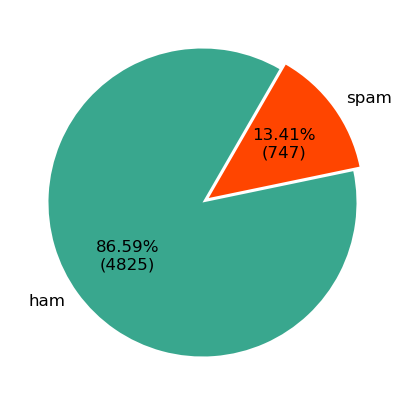

In [6]:
# Visualize the distribution of ham and spam messages in the dataset using a pie plot

label_counts = data['label'].value_counts()
total = len(data['label'])
explode = (0, 0.05)
colors = ['#39a78e','#ff4500']

fig= plt.figure(figsize=(5,5))

# Pie chart

plt.pie(
    label_counts, 
    labels=label_counts.index, 
    autopct=lambda x: '{:.2f}%\n({:.0f})'.format(x, total*x/100),
    colors=colors,
    explode=explode, 
    startangle=60, 
    textprops={'fontsize': 12}
);

The result shows that 13.41% of all the messages are "spam" while 86.59% of the messages are "ham". This indicates that the dataset is not balanced.

## Data preparation

Since the messages are not clean, and the dataset is not balanced, it is necessary to prepare data for machine learning algorithms to reduce the complexity of the feature set and make a more efficient and general algorithm. As part of the preparation, message cleaning, vectorization and dataset balancing will be done. After preprocessing, such a dataset will be used in ML algorithms.

### Data cleaning

The message cleaning process will include the following:
- Lowercasing: Converting all letters to lowercase so that words are not treated as different words due to letter case
- Removing punctuations: Punctuations do not contribute to our model, so removing them minimizes the variations within texts
- Removing numbers: The numbers are removed because they have no impact on the classification of spam or ham messages
- Lemmatizing: Reducing all similar words to their root form.
- Removing stopwords: Stopwords are commonly used words in a language so they have no weight-age. Since the messages in the dataset are written in English, we use an English dictionary.
- Removing extra white space: Performing the above actions leaves extra white space, so it is removed to save memory


In [7]:
def remove_punctuation(message):
    '''Removes punctuation from a message'''
    message_without_punct = list()
    for char in message:
        if char not in string.punctuation:
            message_without_punct.append(char)
    return ''.join(message_without_punct)
 
def remove_stopwords(message):
    '''Removes stopwords from a message'''
    stop_words = set(stopwords.words('english'))
    message_without_stopwords = list()
    for word in message.split():
        if word not in stop_words:
            message_without_stopwords.append(word)
    return ' '.join(message_without_stopwords)  

def lemmatize(message):
    '''Lemmatizes each word from a message into its inflected form (lemma)'''
    wnl = WordNetLemmatizer()
    tokens = word_tokenize(message)
    tokens_lemmatized = list()
    for word in tokens:
        lemma = wnl.lemmatize(word)
        tokens_lemmatized.append(lemma)
    return ' '.join(tokens_lemmatized)

def clean_message(message):
    '''Executes all cleaning actions on a given message'''
    message = message.lower() # lowercasing
    message = remove_punctuation(message) # remove punctuation
    message = re.sub(pattern=r'\d+', repl='', string=message) # remove numbers
    message = re.sub(pattern=r'\s+', repl=' ', string=message) # remove extra white space
    message = lemmatize(message) # lemmatizing
    message = remove_stopwords(message) # remove stopwords

    return message

In [8]:
# Add a new column in dataframe containing clean messages

data['message_clean'] = data['message'].apply(lambda x: clean_message(x))

### Dummy variable

Labels *ham* and *spam* are target values. We create a new dummy variable that will map ham to 0 and spam to 1.

In [9]:
# Add a new column in dataframe containing mapped labels

data['label_clean'] = data.label.map({'ham':0, 'spam':1})

In [10]:
# View first 10 records of the updated dataframe

data.head(10)

,label,message,message_clean,label_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...,1
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though,0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darling week word back id like fun...,1
6,ham,Even my brother is not like to speak with me. ...,even brother like speak treat like aid patent,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,per request melle melle oru minnaminunginte nu...,0
8,spam,WINNER!! As a valued network customer you have...,winner valued network customer selected receiv...,1
9,spam,Had your mobile 11 months or more? U R entitle...,mobile month u r entitled update latest colour...,1


The updated dataframe contains two new columns: *message_clean* and *label_clean*. By comparing the *message* and *message_clean* columns, it can be seen that the message content has been cleaned. In the *label_clean* column "ham" has become "0" and "spam" has become "1".

### Split training and test set

Before the vectorization and dataset balancing is done, the dataset is divided into a training and test set.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data['message_clean'], 
                                                    data['label_clean'], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [12]:
print('Train size (number of records):',len(X_train))
print('Test size (number of records):',len(X_test))

Train size (number of records): 4457
Test size (number of records): 1115


### Vectorization 

To find the weighted features and convert text to numerical vectors, TF-IDF vectorizer is used.

TfidfVectorizer contains parameters that can be used for data cleaning (eg lowercase, stop_words), but since data cleaning was done in the previous step, TfidfVectorizer will use the message_clean content.

TfidfVectorizer contains the parameter max_features. The purpose of max_features is to limit the number of features (words) from the dataset for which we want to calculate the TF-IDF scores.

In [13]:
# Explore the vocabulary to define max_features

vectorizer = TfidfVectorizer(max_features=None) # Define tf-idf vectorizer
vectorizer.fit(X_train) # Learn vocabulary

print('Vocabulary size: {size}'.format(size=len(vectorizer.vocabulary_))) # Print vocabulary size

Vocabulary size: 7000


In [14]:
vectorizer = TfidfVectorizer(max_features=5000) # Define tf-idf vectorizer with max_features
X_train_vec = vectorizer.fit_transform(X_train) # Numericalize the train dataset
X_test_vec = vectorizer.transform(X_test) # Numericalize the test dataset

### Balancing data

Training dataset will be balanced using the SMOTE method. In other words, upsampling of "spam" records will be performed as their occurrence is significantly less frequent than "ham" records.

In [15]:
# View the number of messages per label in training set

y_train.value_counts().rename({0: 'ham', 1: 'spam'})

ham     3859
spam     598
Name: label_clean, dtype: int64

In [16]:
smote = SMOTE(random_state=42) # Defining SMOTE function
X_train_us, y_train_us = smote.fit_resample(X_train_vec, y_train) # Applying SMOTE function on X and y

In [17]:
y_train_us.value_counts().rename({0: 'ham', 1: 'spam'}) # View the number of messages per label in training set after SMOTE operation

spam    3859
ham     3859
Name: label_clean, dtype: int64

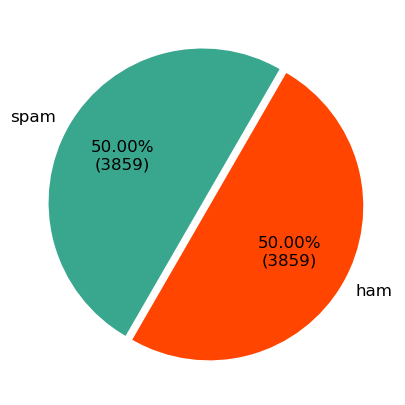

In [51]:
# Result visualization

label_counts_us = y_train_us.value_counts()
total_us = len(y_train_us)
explode = (0, 0.05)
colors = ['#39a78e','#ff4500']

fig= plt.figure(figsize=(5,5))

plt.pie(
    label_counts_us, 
    labels=label_counts_us.rename({0: 'ham', 1: 'spam'}).index, 
    autopct=lambda x: '{:.2f}%\n({:.0f})'.format(x, total_us*x/100),
    colors=colors,
    explode=explode, 
    startangle=60, 
    textprops={'fontsize': 12}
);

## Machine Learning Algorithms

The following machine learning algorithms will be used for classification:
- Random Forest
- Support Vector Classification (SVC)
- Naive Bayes Classifier
- Long short-term memory (LSTM)

### Random Forest

In [19]:
# Define the Random forest classifier

rf = RandomForestClassifier(random_state = 42) 

In order to get more general results, we will use method RandomizedSearchCV to search for optimal hyperparameters.

In [20]:
# Define search space

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(10, 30, num = 5)]
min_samples_split = [5, 10]
min_samples_leaf = [2, 3, 4]
bootstrap = [True, False]

rf_grid_param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [21]:
# Define search

rf_rgrid = RandomizedSearchCV(
    estimator = rf, # Define estimator object 
    param_distributions = rf_grid_param, # Define lists of parameters
    scoring = 'f1', # Define scoring
    n_iter = 5, # Define the number of different combinations
    cv = 5, # Define StratifiedKFold
    verbose = 0, # Define verbosity
    random_state = 42, # Produce the same results across different calls
    n_jobs = -1 # Define number of jobs to run in parallel
) 

In [22]:
# Execute search

rf_rgrid_start = time() # Time before fitting
rf_rgrid.fit(X_train_us, y_train_us) # Fitting
rf_rgrid_end = time() # Time after fitting

In [23]:
# Make prediction

rf_rgrid_prediction = rf_rgrid.predict(X_test_vec)

In [24]:
def display_results(model, y, prediction, start_time, end_time):
    confusion_matrix_plot = confusion_matrix(y, prediction)
    display(pd.DataFrame(data = confusion_matrix_plot, columns = ['HAM Prediction', 'SPAM Prediction'],
            index = ['HAM Class', 'SPAM Class']))
    train_time = (end_time - start_time) # time in seconds
    
    if hasattr(model, 'best_score_'):
        print('Best Score: {:.2f}'.format(model.best_score_))
    if hasattr(model, 'best_params_'):
        print('Best Hyperparameters:',model.best_params_)
    print('Train time: {:.2f} s'.format(train_time))
    
    return

display_results(rf_rgrid, y_test, rf_rgrid_prediction,rf_rgrid_start,rf_rgrid_end)

,HAM Prediction,SPAM Prediction
HAM Class,966,0
SPAM Class,29,120


Best Score: 0.98
Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': False}
Train time: 26.44 s


### Support Vector Classification (SVC)

In [25]:
# Define SVC classifier

svc = svm.SVC(kernel="linear", C = 1) 

In order to get more general results, we will use method GridSearchCV to search for optimal hyperparameters.

In [26]:
# Define search space

svc_grid_param = {"C": [0.1, 1, 10, 100, 1000]}

In [27]:
# Define search

svc_grid = GridSearchCV(estimator = svc, # Define estimator object 
                        param_grid = svc_grid_param, # Define lists of parameters
                        scoring= 'f1', # Define scoring
                        cv = 5, # Define StratifiedKFold
                        verbose = 0, # Define verbosity
                        return_train_score=True, # Include training scores
                        n_jobs = -1) # Define number of jobs to run in parallel

In [28]:
# Execute search

svc_grid_start = time() # Time before fitting
svc_grid.fit(X_train_us, y_train_us) # Fitting
svc_grid_end = time() # Time after fitting

In [29]:
# Make prediction

svc_prediction = svc_grid.predict(X_test_vec)

In [30]:
display_results(svc_grid, y_test, svc_prediction,svc_grid_start,svc_grid_end)

,HAM Prediction,SPAM Prediction
HAM Class,962,4
SPAM Class,14,135


Best Score: 1.00
Best Hyperparameters: {'C': 10}
Train time: 28.14 s


### Naive Bayes Classifier

In [31]:
# Define Naive Bayes classifier

nbc = MultinomialNB() 

In order to get more general results, we will use method GridSearchCV to search for optimal hyperparameters.

In [32]:
# Define search space

nbc_grid_param = {"alpha": [0.2,1,2,5,10], 
                  "fit_prior": [True, False]}

In [33]:
# Define search

nbc_grid = GridSearchCV(estimator = MultinomialNB(), # Define estimator object 
                        param_grid = nbc_grid_param, # Define lists of parameters
                        scoring= 'f1', # Define scoring
                        cv = 5, # Define StratifiedKFold
                        verbose = 0, # Define verbosity
                        return_train_score=True, # Include training scores
                        n_jobs = -1) # Define number of jobs to run in parallel

In [34]:
# Execute search

nbc_grid_start = time() # Time before fitting
nbc_grid.fit(X_train_us,y_train_us) # Fitting
nbc_grid_end = time() # Time after fitting

In [35]:
# Make prediction

nbc_prediction = nbc_grid.predict(X_test_vec)

In [36]:
display_results(nbc_grid, y_test, nbc_prediction,nbc_grid_start,nbc_grid_end)

,HAM Prediction,SPAM Prediction
HAM Class,941,25
SPAM Class,10,139


Best Score: 0.98
Best Hyperparameters: {'alpha': 0.2, 'fit_prior': False}
Train time: 0.30 s


### LSTM

The following algorithm will be executed in a different way, using the keras library. LSTM is an artificial neural network that is effective in memorizing important information.

Previous split into the training and test set will be further divided into training test and validation set, after which tokenization will be applied, followed by padding.

In [37]:
# Split X_test and y_test into validation and test sets

X_val, X_test, Y_val, Y_test = train_test_split(X_test, 
                                                y_test,
                                                test_size=0.5,
                                                random_state=42)

In [38]:
# Tokenize X_train, X_val, X_test

tokenizer = Tokenizer(num_words=5000) # Define tokenizer with 5000 words as in TfidfVectorizer

tokenizer.fit_on_texts(X_train) # Apply tokenizer on X_train
tokenizer.fit_on_texts(X_val) # Apply tokenizer on X_val
tokenizer.fit_on_texts(X_test) # Apply tokenizer on X_test

In [39]:
# Transform each message to a sequence of integers

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

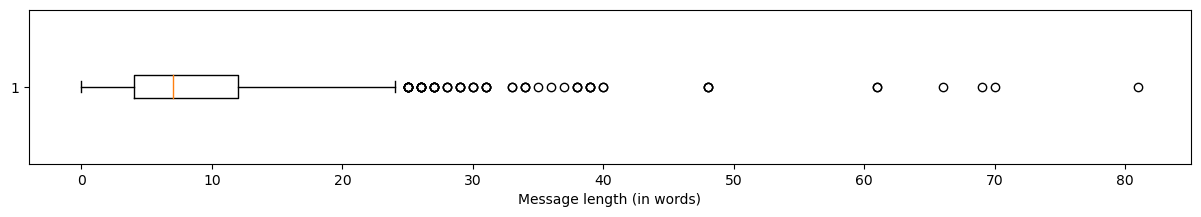

In [40]:
# Analyze the number of words per sentence

result = [len(i) for i in X_train_sequences]

plt.figure(figsize = (15, 2))
plt.boxplot(result, vert = False)
plt.xlabel('Message length (in words)')
plt.show()

The figure above shows that the largest number of messages in the training set has less than 50 words, so 50 will be used as the maximum message length.

In [41]:
# Padding

X_train_message_pad = pad_sequences(X_train_sequences, maxlen=50)
X_val_message_pad = pad_sequences(X_val_sequences, maxlen=50)
X_test_message_pad = pad_sequences(X_test_sequences, maxlen=50)

As can be seen earlier, the training set is not balanced. Therefore, the training set will be balanced using the SMOTE method.

In [42]:
smote = SMOTE(random_state=42) # Define SMOTE function
X_train_ann, y_train_ann = smote.fit_resample(X_train_message_pad, y_train) # Applying SMOTE function on X and y

In [43]:
y_train_ann.value_counts().rename({0: 'ham', 1: 'spam'})

spam    3859
ham     3859
Name: label_clean, dtype: int64

In [44]:
# Build network structure

ann = Sequential()

ann.add(Embedding(input_dim=5000, # Size of the input vocabulary
                    output_dim=100, # Size of the embadding vector (tipically between 100-300)
                    input_length=50)) # Number of words

ann.add(LSTM(units=64)) # Abitrary size

ann.add(Dense(1, activation='sigmoid')) # Binary classification

In [50]:
# Compile the model

ann.compile(optimizer='adam', # Define optimizer
              loss='binary_crossentropy', # Define loss
              metrics=['accuracy']) # Define metrics

In [46]:
# Train the model

ann_start = time() # Time before fitting

ann.fit(X_train_ann,
          y_train_ann,
          validation_data = (X_val_message_pad,Y_val),
          epochs=10,
          verbose=0)

ann_end = time() # Time after fitting

In [47]:
# Make prediction

ann_prediction=ann.predict(X_test_message_pad)
ann_prediction=(ann_prediction>0.5) # If ann_prediction is larger than 0.5 it returns true else false

18/18 [==============================] - 2s 22ms/step


In [48]:
display_results(ann, Y_test, ann_prediction,ann_start,ann_end)

,HAM Prediction,SPAM Prediction
HAM Class,426,55
SPAM Class,2,75


Train time: 100.23 s


## Conclusion

In [49]:
# Display classification report for each algorithm

algorithms = {
    'Random forrest': {'prediction': rf_rgrid_prediction, 'classification': y_test},
    'SVC': {'prediction': svc_prediction, 'classification': y_test},
    'Naive Bayes': {'prediction': nbc_prediction, 'classification': y_test},
    'LSTM': {'prediction': ann_prediction, 'classification': Y_test},
}

for algorithm in algorithms.keys():
    print('Classification report ({algorithm}):'.format(algorithm=algorithm))
    print(classification_report(algorithms[algorithm]['classification'],algorithms[algorithm]['prediction']))
    print()

Classification report (Random forrest):
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.99      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115


Classification report (SVC):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.97      0.91      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115


Classification report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       966
           1       0.85      0.93      0.89       149

    accuracy                           0.97      1115
   macro avg       0

Taking into account the training time and the results for recall and precision, in my opinion SVC is the most optimal model of the used models. However, LSTM gives the best results in recognizing "spam" messages when the messages are truly "spam".